In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Load dataset 
base_dir = os.path.dirname(os.path.abspath('__file__'))
csv_path = os.path.join(base_dir, "./processed/combined_transactions.csv")

df = pd.read_csv(csv_path).sample(frac=1, random_state=42).reset_index(drop=True)

df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Posted Date'] = pd.to_datetime(df['Posted Date'])

time_difference = df['Posted Date'] - df['Transaction Date']

df.insert(0, 'temporal_difference', time_difference.dt.days.astype(float))

# The column 'temporal_difference' is already converted to float, so this line is not needed.
df.drop(columns=['Transaction Date', 'Posted Date', 'Card No.'], inplace=True)

df['Payment'] = df['Debit'] + df['Credit']
df.drop(columns=['Debit', 'Credit'], inplace=True)

# Move 'payment' to be the second column
payment_column = df.pop('Payment')
df.insert(1, 'Payment', payment_column)

df.drop(columns=['Category', 'Description'], inplace=True)

# print(df['Category'].unique())
df.head()


,temporal_difference,Payment,isFraud
0,2.0,18.79,0
1,1.0,5.94,0
2,1.0,75.43,1
3,1.0,7.47,0
4,1.0,2.83,0


In [3]:
# Prepare features (X) and target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Stratified train-test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print( len(X_train))


509


In [4]:

from sklearn.metrics import accuracy_score

# Create Random Forest pipeline with class_weight balanced
clf = RandomForestClassifier(random_state=0, n_estimators=10, max_features=0.8)
# TODO: Train it
clf.fit(X_train, y_train)
# TODO: Predict the test values
clf_pred= clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, clf_pred, target_names=["Not Fraud", "Fraud"]))

# TODO: Obtain the confusion matrix and print it
print(confusion_matrix(y_test, clf_pred))

print(accuracy_score(y_test, clf_pred))

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.91      0.91      0.91        98
       Fraud       0.70      0.70      0.70        30

    accuracy                           0.86       128
   macro avg       0.80      0.80      0.80       128
weighted avg       0.86      0.86      0.86       128

[[89  9]
 [ 9 21]]
0.859375


ROC AUC: 0.9299


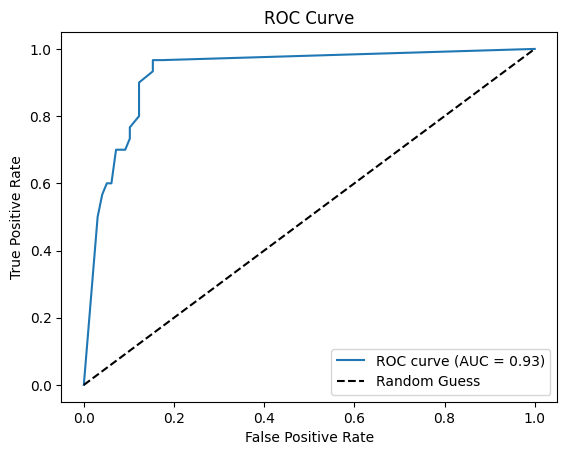

In [5]:
# Compute ROC curve and AUC
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()